In [1]:
from src.data.image_transforms import *
import matplotlib.pyplot as plt
import numpy as np
from src.data.data_utils import *
from src.data.data_loader import ImageLoader
from torch.utils.data import DataLoader
from src.plots.bounding_box import image_with_bounding_box
from src.data.collate import kitti_collate_fn
from PIL import Image
from src.training.optimizer import get_optimizer
import torch
from src.plots.bounding_box import image_with_bounding_box
from src.models.retinanet.resnet import *
from src.training.trainer import Trainer
import warnings
from src.plots.history import plot_history
from src.training.train_utils import predict
import gc
import os
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Use the first argument of the `model` in the cell below to change the number of classes for analysis. Accepts 3 (car, pedestrian, cyclist) or 8 (all labels).

In [3]:
model = resnet152(3, True)
optimizer_config = {"optimizer_type": "adamw", "lr": 1e-5, "weight_decay": 3e-5}
optimizer = get_optimizer(model, optimizer_config)

adamw


Use the `load_from_disk` argument in the cell below to use pre-trained weights.

training data size: 5984 images.


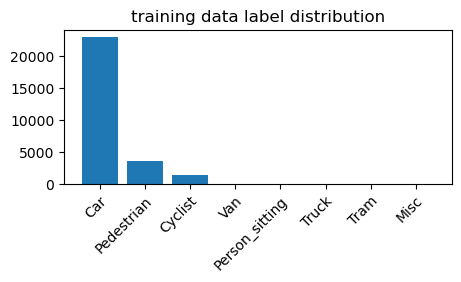

validation data size: 1497 images.


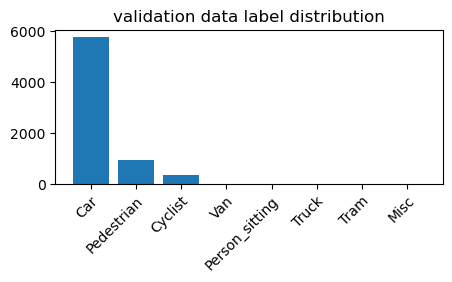

In [4]:
runner = Trainer(data_dir="dataset",
                 model=model,
                 optimizer=optimizer,
                 saved_model_dir="saved_models",
                 train_data_transforms=get_train_transforms(),
                 val_data_transforms=get_val_transforms(),
                 batch_size=8,
                 inp_size=None,
                 load_from_disk=False)

In [5]:
num_epochs = 50
runner.run_training_loop(num_epochs)

Epoch 1:
	Train Total Loss:0.8082
	Train Classwise Average Precision:
		[0.6683 0.1576 0.087 ]
	Validation Total Loss: 0.5669
	Validation Classwise Average Precisions:
		[0.7298 0.1633 0.1198]
Epoch 2:
	Train Total Loss:0.5089
	Train Classwise Average Precision:
		[0.7504 0.1967 0.1272]
	Validation Total Loss: 0.4635
	Validation Classwise Average Precisions:
		[0.7454 0.2068 0.1222]
Epoch 3:
	Train Total Loss:0.4222
	Train Classwise Average Precision:
		[0.7696 0.2117 0.1384]
	Validation Total Loss: 0.4119
	Validation Classwise Average Precisions:
		[0.7686 0.2029 0.1363]
Epoch 4:
	Train Total Loss:0.3693
	Train Classwise Average Precision:
		[0.786  0.2233 0.1401]
	Validation Total Loss: 0.3906
	Validation Classwise Average Precisions:
		[0.7716 0.1892 0.1431]
Epoch 5:
	Train Total Loss:0.3322
	Train Classwise Average Precision:
		[0.7977 0.233  0.1497]
	Validation Total Loss: 0.3663
	Validation Classwise Average Precisions:
		[0.7803 0.2388 0.1805]
Epoch 6:
	Train Total Loss:0.3018
	

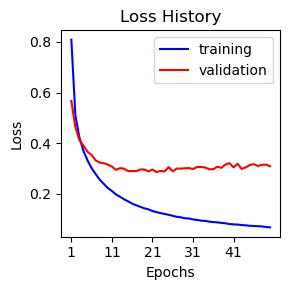

In [6]:
interval = max(1, num_epochs // 5)
plt.figure(figsize=(3, 3))
plot_history(runner.train_loss_history,
        runner.validation_loss_history,
        "Loss",
        "Loss History",
        interval)
plt.tight_layout()
plt.show()

validation data size: 1497 images.


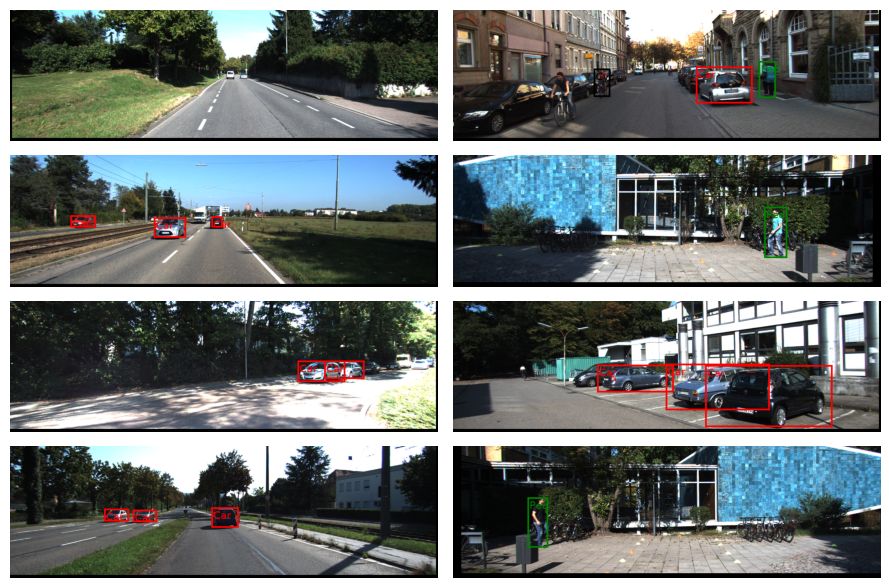

In [7]:
test_dataset = ImageLoader("dataset", "validation", model.num_classes, get_test_transforms())
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=kitti_collate_fn)
checkpoint = torch.load(os.path.join("saved_models", "checkpoint.pt"))
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

plt.figure(figsize=(9, 6))

for image, boxes_labels in test_loader:
    boxes = boxes_labels[:, :, :4]
    ground_truth_labels = boxes_labels[:, :, 4]
    for batch_item in range(len(image)):
        boxedImage = predict(image[batch_item], model, device)
        plt.subplot(4, 2, batch_item + 1)
        plt.imshow(boxedImage)
        plt.axis("off")
    break
plt.tight_layout()
plt.show()

model = model.cpu()
gc.collect()
torch.cuda.empty_cache()

Uncomment the cell below to visualize the generated anchors relative to the dataset image size. The file is exported as `results/anchors.gif`.

In [1]:
# from src.plots.plot_anchors import plotAnchors
# plotAnchors(increment=9)